In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import sys
sys.path.append('/home/josea/DEEP_TIMING/DEEP_TIMING_VS/')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [2]:
from functions import (create_and_delay_pulse_pair, create_position, set_seed, 
                       calculate_gaussian_center, plot_gaussian, get_gaussian_params)

In [3]:
# Load data 
dir = '/home/josea/DEEP_TIMING/DEEP_TIMING_VS/Na22_filtered_data/'

train_data_82 = np.load(os.path.join(dir, 'Na22_82_norm_ALBA_train.npz'))['data']
train_data_55 = np.load(os.path.join(dir, 'Na22_55_norm_ALBA_train.npz'))['data']
train_data_28 = np.load(os.path.join(dir, 'Na22_28_norm_ALBA_train.npz'))['data']


validation_data_82 = np.load(os.path.join(dir, 'Na22_82_norm_ALBA_val.npz'))['data']
validation_data_55 = np.load(os.path.join(dir, 'Na22_55_norm_ALBA_val.npz'))['data']
validation_data_28 = np.load(os.path.join(dir, 'Na22_28_norm_ALBA_val.npz'))['data']


test_data_82 = np.load(os.path.join(dir, 'Na22_82_norm_ALBA_test.npz'))['data']
test_data_55 = np.load(os.path.join(dir, 'Na22_55_norm_ALBA_test.npz'))['data']
test_data_28 = np.load(os.path.join(dir, 'Na22_28_norm_ALBA_test.npz'))['data']

In [4]:
class ConvolutionalModel(nn.Module):
    def __init__(self, N_rows, N_columns):
        super(ConvolutionalModel, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 16, kernel_size = 3, padding = 1, stride = 1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d((2, 2)) # Output: (batch_size, 8, N_rows // 2, N_columns // 2)

        # Calculate the flattened size after the convolutions and pooling
        self.flatten_size = 16 * (N_rows // 2) * (N_columns // 2)  # Adjust according to pooling layers
        
        self.fc1 = nn.Linear(self.flatten_size, 1)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool1(x)
                
        x = x.view(x.size(0), -1)  # Flatten
        
        x = self.fc1(x)
     
        return x    

In [5]:
def custom_loss(outputs_0, outputs_1, labels):
    loss = (torch.mean(abs(outputs_0 - outputs_1 - labels)) +
            torch.sum(torch.relu(-outputs_0)) +
            torch.sum(torch.relu(-outputs_1)))
    return loss


def train_loop_convolutional(model, optimizer, train_loader, val_loader, test_tensor, EPOCHS = 75, checkpoint = 15, name = 'model', save = False):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    test_tensor = test_tensor.to(device)
    
    loss_list = []
    val_loss_list = []
    test = []

    # Cosine Annealing Scheduler
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = EPOCHS)

    for epoch in range(EPOCHS):
        running_loss = 0.0
        model.train()
        for i, data in enumerate(train_loader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero gradients
            optimizer.zero_grad()

            # Make predictions for this batch 
            outputs_0 = model(inputs[:, None, :, :, 0])
            outputs_1 = model(inputs[:, None, :, :, 1])

            # Compute the loss and its gradients
            loss = custom_loss(outputs_0, outputs_1, labels)
            loss.backward()

            # Adjust learning weights
            optimizer.step()
            
            # Accumulate running loss
            running_loss += loss.item()

        # Step the scheduler
        scheduler.step()

        # Calculate average loss per epoch
        avg_loss_epoch = running_loss / (i)  
        loss_list.append(avg_loss_epoch)

        print(f'EPOCH {epoch + 1}: LOSS train {avg_loss_epoch}')

        # Calculate predictions on test_tensor
        model.eval()
        with torch.no_grad():
            test_epoch = model(test_tensor[:, None, :, :])
            test.append(np.squeeze(test_epoch.cpu().numpy()))

            val_loss = 0
            for val_data, val_labels in val_loader:
                val_data, val_labels = val_data.to(device), val_labels.to(device)
                val_0 = model(val_data[:, None, :, :, 0])
                val_1 = model(val_data[:, None, :, :, 1])
                val_loss += custom_loss(val_0, val_1, val_labels)
        val_loss_list.append(val_loss.cpu().numpy() / len(val_loader))
        print(f'LOSS val {val_loss / len(val_loader)}')


        if save and (epoch + 1) % checkpoint == 0:
            model_name = f'{name}_{epoch + 1}.pth'
            torch.save(model.state_dict(), model_name)

    # Convert lists to numpy arrays
    loss_array = np.array(loss_list, dtype = 'object')
    test = np.array(test, dtype = 'object')
    val = np.array(val_loss_list, dtype = 'object')
    
    return loss_array, test, val

In [6]:
# Important definitions
time_step = 0.2 
delay_time = 1
nbins = 71  # Num bins for all histograms                          
t_shift = 1  # Time steps to move for the new positions
start = 40
stop = 94
set_seed(42) #Fix seeds
epochs = 500
lr = 1e-4

In [7]:
train_data = np.concatenate((train_data_55, train_data_28, train_data_82), axis = 0)
validation_data = np.concatenate((validation_data_55, validation_data_28, validation_data_82), axis = 0)
test_data = np.concatenate((test_data_55, test_data_28, test_data_82), axis = 0)

train_data = train_data[:,start:stop,:]
validation_data = validation_data[:,start:stop,:] 
test_data = test_data[:,start:stop,:]

print('Número de casos de entrenamiento: ', train_data.shape[0])
print('Número de casos de test: ', test_data.shape[0])

Número de casos de entrenamiento:  12000
Número de casos de test:  21993


In [16]:
train_dec0, REF_train_dec0 = create_and_delay_pulse_pair(train_data[:,:,0], time_step, delay_time = delay_time)
train_dec1, REF_train_dec1 = create_and_delay_pulse_pair(train_data[:,:,1], time_step, delay_time = delay_time)

val_dec0, REF_val_dec0 = create_and_delay_pulse_pair(validation_data[:,:,0], time_step, delay_time = delay_time)
val_dec1, REF_val_dec1 = create_and_delay_pulse_pair(validation_data[:,:,1], time_step, delay_time = delay_time)

TEST = test_data

# **SPECTOGRAMS**

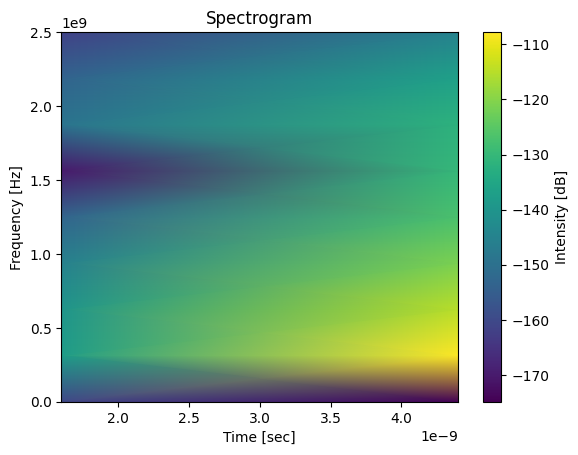

In [17]:
from scipy import signal

fs = 5*(10**9) # Sample frequency in hz (5Gsamples/s)
nperseg = 16
# Calculate sample spectrogram
f, t, Sxx = signal.spectrogram(train_dec0[0,:,0], fs, nperseg = nperseg)
Sxx_db = 10 * np.log10(Sxx) # In decibel scale

# Plot
plt.pcolormesh(t, f, Sxx_db, shading = 'gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('Spectrogram')
plt.colorbar(label = 'Intensity [dB]')
plt.show()

In [18]:
spectogram_train_dec0 = np.zeros((train_dec0.shape[0], Sxx.shape[0], Sxx.shape[1], 2))
spectogram_train_dec1 = np.zeros((train_dec1.shape[0], Sxx.shape[0], Sxx.shape[1], 2))

spectogram_val_dec0 = np.zeros((val_dec0.shape[0], Sxx.shape[0], Sxx.shape[1], 2))
spectogram_val_dec1 = np.zeros((val_dec1.shape[0], Sxx.shape[0], Sxx.shape[1], 2))

spectogram_test = np.zeros((TEST.shape[0], Sxx.shape[0], Sxx.shape[1], 2))

# Fill training spectograms
for i in range(train_dec0.shape[0]):

    f_chn0, t_chn0, Sxx_chn0_dec0 = signal.spectrogram(train_dec0[i, :, 0], fs, nperseg = nperseg)
    f_chn1, t_chn1, Sxx_chn1_dec0 = signal.spectrogram(train_dec0[i, :, 1], fs, nperseg = nperseg)
    
    f_chn0, t_chn0, Sxx_chn0_dec1 = signal.spectrogram(train_dec1[i, :, 0], fs, nperseg = nperseg)
    f_chn1, t_chn1, Sxx_chn1_dec1 = signal.spectrogram(train_dec1[i, :, 1], fs, nperseg = nperseg)

    spectogram_train_dec0[i, :, :, 0] = 10 * np.log10(Sxx_chn0_dec0) # In decibel scale
    spectogram_train_dec0[i, :, :, 1] = 10 * np.log10(Sxx_chn1_dec0) 
    spectogram_train_dec1[i, :, :, 0] = 10 * np.log10(Sxx_chn0_dec1) 
    spectogram_train_dec1[i, :, :, 1] = 10 * np.log10(Sxx_chn1_dec1) 

# Fill validation spectograms
for i in range(val_dec0.shape[0]):

    f_chn0, t_chn0, Sxx_chn0_dec0 = signal.spectrogram(val_dec0[i, :, 0], fs, nperseg = nperseg)
    f_chn1, t_chn1, Sxx_chn1_dec0 = signal.spectrogram(val_dec0[i, :, 1], fs, nperseg = nperseg)
    
    f_chn0, t_chn0, Sxx_chn0_dec1 = signal.spectrogram(val_dec1[i, :, 0], fs, nperseg = nperseg)
    f_chn1, t_chn1, Sxx_chn1_dec1 = signal.spectrogram(val_dec1[i, :, 1], fs, nperseg = nperseg)

    spectogram_val_dec0[i, :, :, 0] = 10 * np.log10(Sxx_chn0_dec0) # In decibel scale
    spectogram_val_dec0[i, :, :, 1] = 10 * np.log10(Sxx_chn1_dec0) 
    spectogram_val_dec1[i, :, :, 0] = 10 * np.log10(Sxx_chn0_dec1) 
    spectogram_val_dec1[i, :, :, 1] = 10 * np.log10(Sxx_chn1_dec1) 

# Fill test spectograms
for i in range(TEST.shape[0]):

    f_chn0, t_chn0, Sxx_chn0 = signal.spectrogram(TEST[i, :, 0], fs, nperseg = nperseg)
    f_chn1, t_chn1, Sxx_chn1 = signal.spectrogram(TEST[i, :, 1], fs, nperseg = nperseg)
    
    spectogram_test[i, :, :, 0] = 10 * np.log10(Sxx_chn0) # In decibel scale
    spectogram_test[i, :, :, 1] = 10 * np.log10(Sxx_chn1) 

In [19]:
# Create Dataset / DataLoaders
train_dataset_dec0 = torch.utils.data.TensorDataset(torch.from_numpy(spectogram_train_dec0).float(), torch.from_numpy(np.expand_dims(REF_train_dec0, axis = -1)).float())
train_dataset_dec1 = torch.utils.data.TensorDataset(torch.from_numpy(spectogram_train_dec1).float(), torch.from_numpy(np.expand_dims(REF_train_dec1, axis = -1)).float())

val_dataset_dec0 = torch.utils.data.TensorDataset(torch.from_numpy(spectogram_val_dec0).float(), torch.from_numpy(np.expand_dims(REF_val_dec0, axis = -1)).float())
val_dataset_dec1 = torch.utils.data.TensorDataset(torch.from_numpy(spectogram_val_dec1).float(), torch.from_numpy(np.expand_dims(REF_val_dec1, axis = -1)).float())

train_loader_dec0 = torch.utils.data.DataLoader(train_dataset_dec0, batch_size = 32, shuffle = True)
train_loader_dec1 = torch.utils.data.DataLoader(train_dataset_dec1, batch_size = 32, shuffle = True)

val_loader_dec0 = torch.utils.data.DataLoader(val_dataset_dec0, batch_size = len(val_dataset_dec0), shuffle = False)
val_loader_dec1 = torch.utils.data.DataLoader(val_dataset_dec1, batch_size = len(val_dataset_dec1), shuffle = False)

# **MODEL**

In [20]:
# Initialize model
model_dec0 = ConvolutionalModel(spectogram_train_dec0.shape[1], spectogram_train_dec0.shape[2])
model_dec1 = ConvolutionalModel(spectogram_train_dec1.shape[1], spectogram_train_dec1.shape[2])

# Initialize optimizer
optimizer_dec0 = torch.optim.AdamW(model_dec0.parameters(), lr = lr)
optimizer_dec1 = torch.optim.AdamW(model_dec1.parameters(), lr = lr)

In [21]:
# Execute train loop
loss_dec0, test_dec0, val_dec0 = train_loop_convolutional(model_dec0, optimizer_dec0, train_loader_dec0, val_loader_dec0, torch.tensor(spectogram_test[:,:,:,0]).float(), EPOCHS = epochs, save = False) 
loss_dec1, test_dec1, val_dec1 = train_loop_convolutional(model_dec1, optimizer_dec1, train_loader_dec1, val_loader_dec1, torch.tensor(spectogram_test[:,:,:,1]).float(), EPOCHS = epochs, save = False) 

EPOCH 1: LOSS train 0.3639584652242813
LOSS val 0.34807857871055603
EPOCH 2: LOSS train 0.34487187400221186
LOSS val 0.33121681213378906
EPOCH 3: LOSS train 0.32536526625966006
LOSS val 0.30615943670272827
EPOCH 4: LOSS train 0.29535205200075465
LOSS val 0.27172917127609253
EPOCH 5: LOSS train 0.2559866815167952
LOSS val 0.23200714588165283
EPOCH 6: LOSS train 0.2074648839506236
LOSS val 0.17289048433303833
EPOCH 7: LOSS train 0.1598704467642116
LOSS val 0.12903033196926117
EPOCH 8: LOSS train 0.12630791179238157
LOSS val 0.10281399637460709
EPOCH 9: LOSS train 0.10613612180207184
LOSS val 0.0870005413889885
EPOCH 10: LOSS train 0.09474309703165834
LOSS val 0.0780598521232605
EPOCH 11: LOSS train 0.08850055513654483
LOSS val 0.07102200388908386
EPOCH 12: LOSS train 0.08624827537068071
LOSS val 0.06643678992986679
EPOCH 13: LOSS train 0.08043876545314482
LOSS val 0.11815068125724792
EPOCH 14: LOSS train 0.07424545831938478
LOSS val 0.05752630531787872
EPOCH 15: LOSS train 0.072287226265

In [25]:
# Calculate TOF
TOF = test_dec0 - test_dec1

TOF_V00 = TOF[:,:test_data_55.shape[0]] 
TOF_V02 = TOF[:, test_data_55.shape[0] : test_data_55.shape[0] + test_data_28.shape[0]] 
TOF_V20 = TOF[:, test_data_55.shape[0]  + test_data_28.shape[0]:] 
    

# Calulate Validation error
centroid_V00 = calculate_gaussian_center(TOF_V00, nbins = nbins, limits = 3) 
    
error_V02 = abs((TOF_V02 - centroid_V00[:, np.newaxis] + t_shift*time_step))
error_V00 = abs((TOF_V00 - centroid_V00[:, np.newaxis]))
error_V20 = abs((TOF_V20 - centroid_V00[:, np.newaxis] - t_shift*time_step))


# Get MAE
Error = np.concatenate((error_V02, error_V20, error_V00), axis = 1)   
MAE = np.mean(Error, axis = 1)
print(MAE[-1])

0.09932819213644999


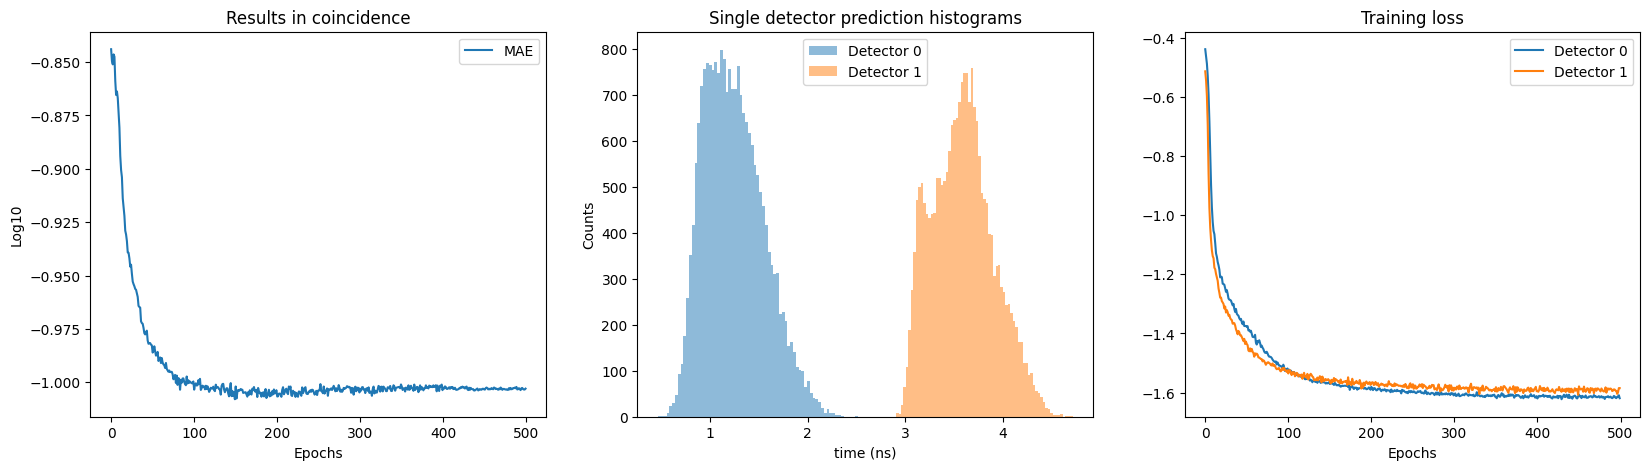

In [26]:
# Plot
plt.figure(figsize = (20,5))
plt.subplot(131)
plt.plot(np.log10(MAE.astype('float64')), label = 'MAE')
plt.title('Results in coincidence')
plt.xlabel('Epochs')
plt.ylabel('Log10')
plt.legend()

plt.subplot(132)
plt.hist(test_dec0[-1,:], bins = nbins, alpha = 0.5, label = 'Detector 0');
plt.hist(test_dec1[-1,:], bins = nbins, alpha = 0.5, label = 'Detector 1');
plt.title('Single detector prediction histograms')
plt.xlabel('time (ns)')
plt.ylabel('Counts')
plt.legend()

plt.subplot(133)
plt.plot(np.log10(loss_dec0.astype('float32')), label = 'Detector 0')
plt.plot(np.log10(loss_dec1.astype('float32')), label = 'Detector 1')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

V20: CENTROID(ns) = 0.1882 +/- 0.00113  FWHM(ns) = 0.3050 +/- 0.00126
V00: CENTROID(ns) = -0.0005 +/- 0.00087  FWHM(ns) = 0.2727 +/- 0.00096
V02: CENTROID(ns) = -0.1685 +/- 0.00113  FWHM(ns) = 0.2866 +/- 0.00125



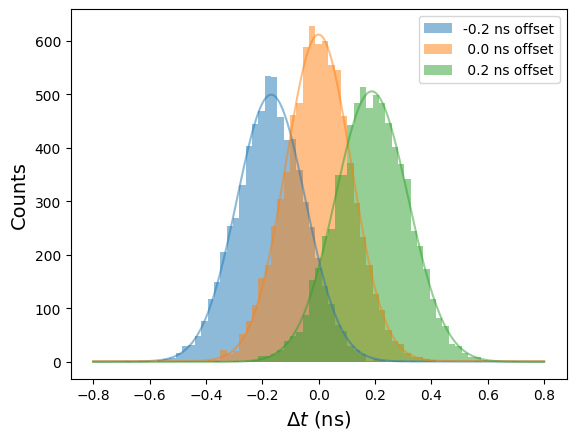

In [27]:
# Histogram and gaussian fit 
plot_gaussian(TOF_V02[-1,:], centroid_V00[-1], range = 0.8, label = '-0.2 ns offset', nbins = nbins)
plot_gaussian(TOF_V00[-1,:], centroid_V00[-1], range = 0.8, label = ' 0.0 ns offset', nbins = nbins)
plot_gaussian(TOF_V20[-1,:], centroid_V00[-1], range = 0.8, label = ' 0.2 ns offset', nbins = nbins)

params_V02, errors_V02 = get_gaussian_params(TOF_V02[-1,:], centroid_V00[-1], range = 0.8, nbins = nbins)
params_V00, errors_V00 = get_gaussian_params(TOF_V00[-1,:], centroid_V00[-1], range = 0.8, nbins = nbins)
params_V20, errors_V20 = get_gaussian_params(TOF_V20[-1,:], centroid_V00[-1], range = 0.8, nbins = nbins)

print("V20: CENTROID(ns) = %.4f +/- %.5f  FWHM(ns) = %.4f +/- %.5f" % (params_V20[2], errors_V20[2], params_V20[3], errors_V20[3]))
print("V00: CENTROID(ns) = %.4f +/- %.5f  FWHM(ns) = %.4f +/- %.5f" % (params_V00[2], errors_V00[2], params_V00[3], errors_V00[3]))
print("V02: CENTROID(ns) = %.4f +/- %.5f  FWHM(ns) = %.4f +/- %.5f" % (params_V02[2], errors_V02[2], params_V02[3], errors_V02[3]))

print('')
plt.legend()
plt.xlabel('$\Delta t$ (ns)', fontsize = 14)
plt.ylabel('Counts', fontsize = 14)
plt.show()

# EN COINCIDENCIAS

usar ya desplazados, mas rapido